In [1]:
import numpy as np
import pandas as pd

import random
import os
from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt

from astropy.visualization import make_lupton_rgb
plt.style.use('dark_background')

In [2]:
hdu_list = fits.open('Unique_positives_complete_fixed.fits')
print('Num. single candidates: ', len(hdu_list[1].data))
images_sing = hdu_list[1].data
images_sing = images_sing[:,0:3,:,:]
data_sing = pd.DataFrame(hdu_list[2].data)
hdu_list.close()

filepath = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/vit_cnn_multiclass_double/results/'
hdu_list = fits.open(filepath + 'Unique_double_complete_fixed.fits')
print('Num. double candidates: ', len(hdu_list[1].data))
images_doub = hdu_list[1].data
images_doub = images_doub[:,0:3,:,:]
data_doub = pd.DataFrame(hdu_list[2].data)
mask = data_doub['COADD_OBJECT_ID'].isin(data_sing['COADD_OBJECT_ID'])
duplicated = data_doub[mask]
print('Num. in intersection: ', len(duplicated))
data_doub = data_doub.drop(duplicated.index)
images_doub = images_doub[data_doub.index]
hdu_list.close()

images = np.concatenate((images_sing, images_doub)).astype(np.float32)
data = pd.concat([data_sing, data_doub], axis=0).reset_index(drop=True)

print('Num. total candidates: ', len(images), len(data))

Num. single candidates:  20653
Num. double candidates:  2540
Num. in intersection:  493
Num. total candidates:  22700 22700


In [3]:
known_data = pd.read_csv('SLED_lens_database.csv')
print(len(known_data))

print('Confirmed: ', len(known_data[known_data['flag_confirmed'] == True]))
print('Not confirmed: ', len(known_data[known_data['flag_confirmed'] == False]))
print(' ')
print('Galaxy lensing: ', len(known_data[known_data['type'] == 'GAL']))
print('QSO lensing: ', len(known_data[known_data['type'] == 'QSO']))
print('SN lensing: ', len(known_data[known_data['type'] == 'SN']))

known_data.head()

14938
Confirmed:  818
Not confirmed:  14120
 
Galaxy lensing:  13037
QSO lensing:  1896
SN lensing:  5


,name,ra,dec,bibcode,flag_confirmed,type
0,SDSSJ0058-1020,14.52800,-10.33700,2017ApJ...851...48S,False,GAL
1,SDSSJ0139-1035,24.88329,-10.58431,2017ApJ...851...48S,False,GAL
2,SDSSJ0143-1006,25.98575,-10.10936,2017ApJ...851...48S,True,GAL
3,SDSSJ0159-0006,29.87558,-0.10344,2017ApJ...851...48S,True,GAL
4,SDSSJ0206+0115,31.74983,1.25481,2017ApJ...851...48S,False,GAL


In [10]:
qso_data = known_data[known_data['type'] == 'QSO']
path_edu = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/training_sample/For_tutorial/education/'
qso_data = qso_data.drop(['name', 'bibcode', 'flag_confirmed', 'type'], axis=1)
qso_data.to_csv(path_edu + 'qso_known.csv', index=False)

In [4]:
size = 0.0032
numpix = 45
columns = list(data.columns) + list(known_data.columns)

images_det, data_det = np.zeros((1,3,numpix,numpix)), pd.DataFrame(columns = columns)
counter = 0

for (i_index, row) in known_data.iterrows():
    #if(i_index > 200): break
    ra, dec = row['ra'], row['dec']
    data_tmp = data[data['RA'] > ra - size][data['RA'] < ra + size][data['DEC'] > dec - size][data['DEC'] < dec + size]
    if(len(data_tmp) > 0): counter += 1
    for (j_index, j_row) in data_tmp.iterrows():
        new_row = pd.concat([row, j_row])
        data_det = data_det.append(new_row, ignore_index=True)
        images_det = np.append(images_det, [images[j_index]], axis = 0)
        
images_det = np.delete(images_det, 0, axis = 0)
print(len(images_det), len(data_det))
print('Unique number: ' + str(counter))

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


1453 1453
Unique number: 1427


In [5]:
print('Confirmed: ', len(data_det[data_det['flag_confirmed'] == True]))
print('Not confirmed: ', len(data_det[data_det['flag_confirmed'] == False]))
print(' ')
print('Galaxy lensing: ', len(data_det[data_det['type'] == 'GAL']))
print('QSO lensing: ', len(data_det[data_det['type'] == 'QSO']))
print('SN lensing: ', len(data_det[data_det['type'] == 'SN']))

Confirmed:  2
Not confirmed:  1451
 
Galaxy lensing:  1451
QSO lensing:  2
SN lensing:  0


In [6]:
def make_plot_all(objects, title, data):
    #print(title)
    for i in range(len(objects)):
        if(i%6 == 0):
            plt.figure(figsize=(16,9))
            for j in range(6):
                if(i+j > len(objects)-1): break
                plt.subplot(1,6,j+1)
                print(data['COADD_OBJECT_ID'].iloc[i+j], data['MAG_AUTO_G'].iloc[i+j])
                new_title = 'Prob: {:.4f}'.format(data['PROB'].iloc[i+j])
                plt.title(new_title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=9., stretch=80.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.show()

Confirmed:
1352988627 21.10251617
1453333773 23.08387566


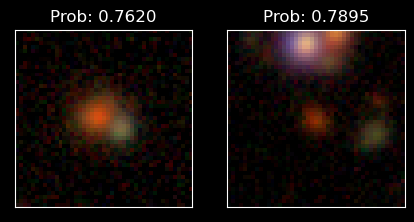

QSO:
1352988627 21.10251617
1453333773 23.08387566


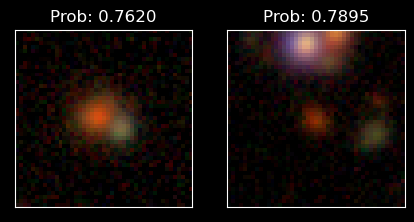

In [7]:
print('Confirmed:')
make_plot_all(images_det[data_det[data_det['flag_confirmed'] == True].index], 'title', data_det[data_det['flag_confirmed'] == True])
print('QSO:')
make_plot_all(images_det[data_det[data_det['type'] == 'QSO'].index], 'title', data_det[data_det['type'] == 'QSO'])

1083587736 22.09349823
1604164262 22.1944313
1470342587 21.09031296
1235391858 20.8092308
1214520967 20.83076096
1466401262 21.30669975


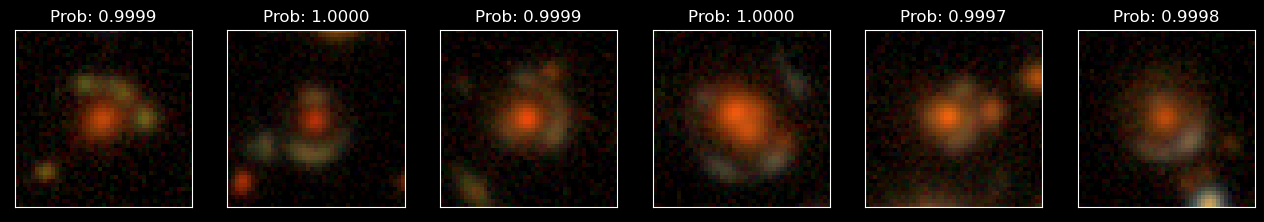

1429256248 20.45302963
1027020579 20.79781342
1027020579 20.79781342
1005730815 20.66174316
1425127607 20.20038986
1015482810 21.2389698


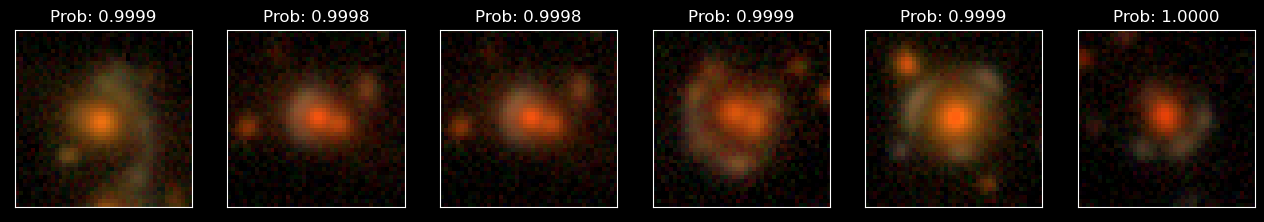

1196484135 20.79967117
1163516688 20.97483253
1569046306 20.75336838
958711616 21.40886116
1117638986 21.36431122
1584250649 20.71852303


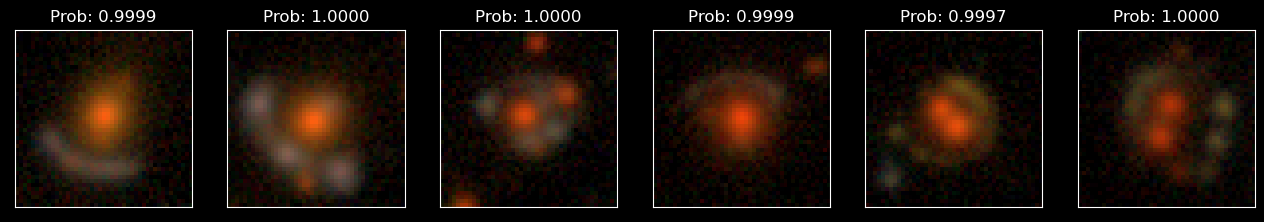

1079483296 21.37029648
1079483541 23.16585541
1425763095 20.94599152
1282283042 21.358778
1487450211 22.76503372
1075990880 21.77248192


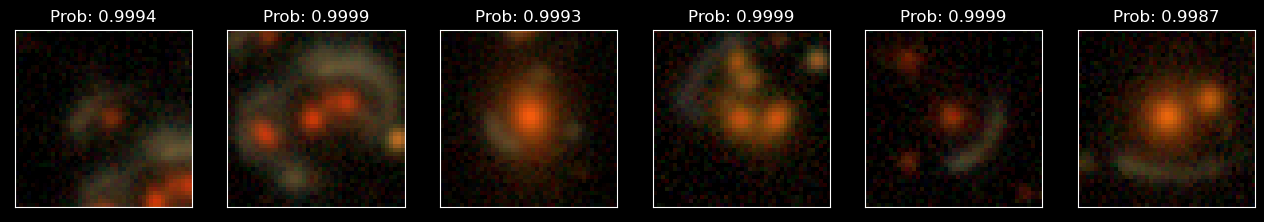

1054556683 20.13426781
1458221488 21.41335678
1194748640 21.35130882
1225062343 20.56396675
1136639478 21.05068016
1305035224 19.53115845


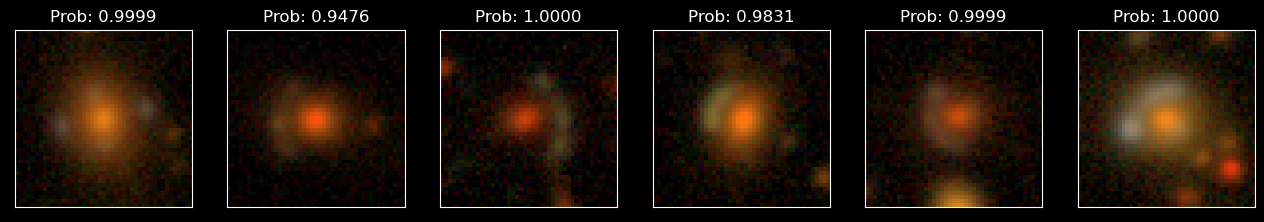

In [8]:
N = 30 #len(images_det) - 1
make_plot_all(images_det[0:N], 'title', data_det.iloc[0:N])

In [9]:
def write_fit_file(name, x, data):
    my_types = {'COADD_OBJECT_ID': int, 'TILENAME': str, 'PROB': float, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': int, 'IMAFLAGS_ISO_R': int, 'IMAFLAGS_ISO_I': int,
       'IMAFLAGS_ISO_Z': int, 'EXT_COADD': int, 'name': str, 'ra': float, 'dec': float, 'bibcode': str,
       'flag_confirmed': bool, 'type': str}
    data = data.astype(my_types)
    
    primary = fits.PrimaryHDU()
    image = fits.ImageHDU(x, name="IMAGE")
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image, table])
    hdu_list.writeto('modeling/' + name + '.fits', overwrite=True)   
    hdu_list.close()

In [10]:
write_fit_file('Previously_found', images_det, data_det)

In [11]:
def make_one_plot(objects, title, data, Q, stretch, minimum):
    plt.figure(figsize=(4,4))
    rgb = make_lupton_rgb(objects[2], objects[1], objects[0], Q=Q, stretch=stretch, minimum=minimum)
    plt.imshow(rgb, aspect='equal')
    plt.xticks([], [])
    plt.yticks([], []) 
    plt.savefig(png_path + str(title) + '.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [12]:
filepath = '/Users/jimenagonzalez/research/DSPL/SpaceWarps_Inspection/training_sample/For_tutorial/education/'
png_path = filepath + 'pngs/'
to_save = pd.read_csv(filepath + 'to_save.csv')

mask = data_det['COADD_OBJECT_ID'].isin(to_save['ID'])
data_save = data_det[mask]
img_save = images_det[data_save.index]
#data_save = data_save.reset_index(drop=True)

for i in range(len(data_save)):
    title = data_save['COADD_OBJECT_ID'].iloc[i]
    #print(title)
    minimum = (0,0,0)
    #make_one_plot(img_save[i], title, data_save.iloc[i], Q=9, stretch=80, minimum=minimum)